### Vanden-Eijnden 

In [1]:
using PyPlot, StatsBase, Printf, DelimitedFiles, Combinatorics;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/nakayama/.julia/packages/Revise/AMRie/src/Revise.jl:1167
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nakayama/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


### Potential energy function its gradients

In [2]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0])

0.0

In [3]:
grad(x; k= 1.0) =  - k .* x .+ k .* x.^3

grad (generic function with 1 method)

In [4]:
ISgrad(x, beta_replica, beta_sigma; k=1.0) = (-k .* x .+ k .* x.^3) ./ beta_replica .* beta_sigma

ISgrad (generic function with 1 method)

In [5]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.9349848424401905

### Define functions for infinite swapping

あるi番目のレプリカのpdf
\begin{align}
{\rho}_i({\bf x_i}) =  e^{-V({\bf x_i})/T_i}
\end{align}

系全体のpdfをQ(x)とするとき
ある置換σのpdfは
\begin{align}
Q(\sigma ,X) =1/N! {\rho}_{\sigma(1)}({\bf x_1}),...,{\rho}_{\sigma(N)}({\bf x_N})
\end{align}

ある置換σでのポテンシャル
\begin{align}
V(X, \sigma) = -\beta^{-1}{\bf log}Q(\sigma,X)=\beta^{-1}\sum_{i=1}^{N}\beta_{\sigma(i)}V(x_i)+const
\end{align}

運動方程式
\begin{align}
ma_j=-\beta^{-1}\beta_{\sigma(j)}\nabla V(x_j)-\gamma mv+\sqrt{2\gamma m \beta^{-1}} 
\end{align}

次のステップの座標計算
\begin{align}
x_{next}=x_{current} -{\Delta t} \nabla{V(x_{current})} + \sqrt{2 \Delta t\beta^{-1}}(rand)
\end{align}


ISREMDの運動方程式
\begin{align}
ma_j=-\beta^{-1}\sum_{\sigma} \beta_{\sigma(j)}\omega_x(\sigma)\nabla V(x_j)-\gamma mv+ \sqrt{2\gamma m \beta^{-1}} 
\end{align}

ISREMDの
次のステップの座標計算
\begin{align}
x_{next}=x_{current} -{\Delta t}\nabla{V(x_{current})}\beta^{-1}_{replica}\sum_{\sigma}\beta _{\sigma(replica)} \omega_X(\sigma) + \sqrt{2 \Delta t\beta^{-1}}(rand)
\end{align}


各置換の重み

\begin{align}
\omega_X({\sigma}):= \frac{   Q(\sigma,X)}{ \sum_{{\sigma}'}Q({\sigma}',X)}
\end{align}

\begin{align}
<A>_j=\int A(x)\rho_j(x)dx
=\int \sum_{j=1}^N A(x_i)\sum_{\sigma}1_{j=\sigma(j)}\omega_x(\sigma)
    \end{align}

##温度Tにおけるxの分布は、以下のπに比例する

\begin{align}
\pi({\bf x},T) = e^{-V({\bf x})/T}
\end{align}

In [6]:
rho(x, T) = exp.(-V(x) ./ T)

rho (generic function with 1 method)

In [7]:
function calc_omega!(omega, x, T, perm)
    nreplica = length(x)   
    nperm=length(perm)
    qu = ones(Float64,nperm)
    qu_sum = 0.0
    for n = 1:nperm
        for i = 1:nreplica
            qu[n] *= rho(x[i], T[perm[n][i]])
        end
        qu[n] = 1/nperm * qu[n]
        qu_sum += qu[n]
    end
    for n = 1:nperm
        omega[n] = qu[n] / qu_sum
    end
end

calc_omega! (generic function with 1 method)

In [8]:
function calc_betasigma!(beta_sigma,beta_replica,perm,omega)
    beta_sigma .= 0.0
    nreplica=length(beta_replica)
    nperm=length(perm)
    for i=1:nreplica
        for n=1:nperm
            beta_sigma[i] += beta_replica[perm[n][i]] * omega[n]
        end
    end
end

calc_betasigma! (generic function with 1 method)

In [9]:
function flush_weight(io::IOStream, m, omega, perm)
    nperm = length(perm)
    nreplica = length(perm[1])
    weight = zeros(Float64, nreplica)
    
    for n = 1:nperm
        #id_replica = perm[n][m]
        id_replica = findall(iszero, perm[n] .- m)[1]
        weight[id_replica] += omega[n]
    end
    
    for i = 1:nreplica
        @printf(io, "%f ", weight[i])
    end
    @printf(io, "\n")
end

flush_weight (generic function with 1 method)

In [26]:
function exchange_temperature!(m2i, i2m, icount, x_replica, pot_fun::Function, temperature_replica)
    nreplica = length(x_replica)

    m_array = 1:nreplica
    t_array = temperature_replica[m_array]
    b_array = 1.0 ./ t_array
    i_array = m2i[m_array]
    v_array = map(pot_fun, x_replica[i_array])
    
    if mod(icount, 2) == 0
        m_lower = 1:2:(nreplica-1)
        m_higher = 2:2:nreplica
    else
        m_lower = 2:2:(nreplica-1)
        m_higher = 3:2:nreplica
    end
    
    iaccepted = 0
    for ipair = 1:length(m_higher)
        m1 = m_lower[ipair]
        m2 = m_higher[ipair]
        delta = (b_array[m2] - b_array[m1]) * (v_array[m1] - v_array[m2])
        if exp(-delta) > rand()
            m2i[m_array[m1]], m2i[m_array[m2]] = m2i[m_array[m2]], m2i[m_array[m1]]
            i2m[i_array[m1]], i2m[i_array[m2]] = i2m[i_array[m2]], i2m[i_array[m1]]
            iaccepted += 1
        end
    end

    return iaccepted / length(m_higher)
end

exchange_temperature! (generic function with 1 method)

### Infinite swap MCMC

In [42]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];

nstep = 100;
nexchange = 200;
perm=collect(permutations(1:nreplica))
nperm=factorial(nreplica)
omega=zeros(Float64,nperm)
beta_sigma=zeros(Float64,nreplica)
beta_replica=1 ./ temperature_replica
m2i = collect(1:nreplica)
i2m = collect(1:nreplica)


x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "exIS_replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end



io_weight=[]
for m = 1:nreplica
    filename = "exIS_weight$(m).dat"
    io = open(filename, "w")
    push!(io_weight, io)
end


In [43]:
   
icount = 0
acceptance_ratio = 0.0
for iexchange = 1:nexchange
    for istep = 1:nstep
        for i = 1:nreplica
            calc_omega!(omega, x_replica, temperature_replica, perm)
            calc_betasigma!(beta_sigma, beta_replica, perm, omega)
       #    x_replica[i] = propagate_md(y -> grad(y,k=2.0), x_replica[i], temperature_replica[perm[n][i]], nstep=1, io=io_replica[i]);       
            x_replica[i] = propagate_md(y -> ISgrad(y,beta_replica[i2m[i]],beta_sigma[i2m[i]],k=1.0), x_replica[i], temperature_replica[i2m[i]], nstep=1, io=io_replica[i]);       
        end
    
        for  m=1:nreplica
          flush_weight(io_weight[m], m, omega, perm)
        end
    end
    acceptance_ratio += exchange_temperature!(m2i, i2m, icount, x_replica, y -> V(y, k=1.0), temperature_replica)
    icount += 1
end
acceptance_ratio = acceptance_ratio / nexchange

0.85175

In [44]:
for i = 1:nreplica
    close(io_replica[i])
    close(io_weight[i])
end

### Trajectory analysis

In [45]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "exIS_replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

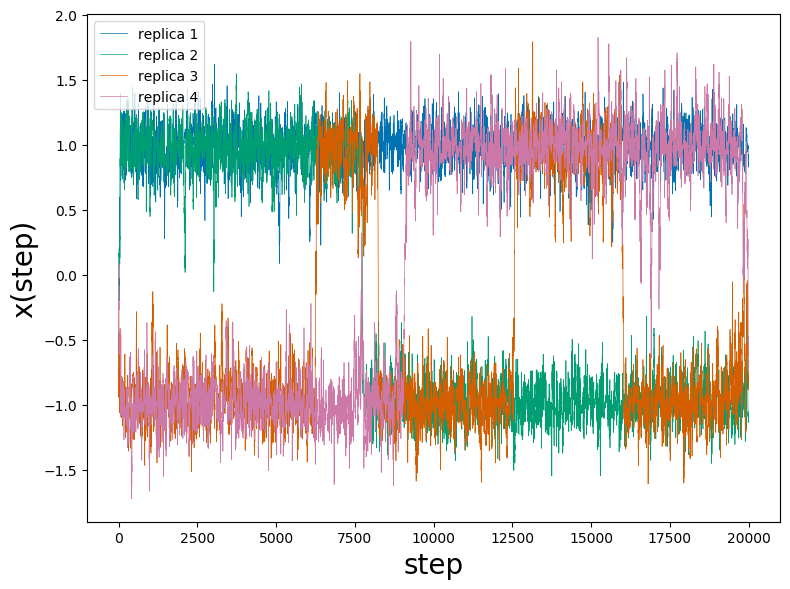

In [46]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [47]:
# sort trajectories according to temperature
function sort_traj(traj_replica, temp_replica)
    traj_sorted = deepcopy(traj_replica)
    temp_sorted = deepcopy(temp_replica)
    nframe = size(traj_replica[1], 1)
    for iframe = 1:nframe
        temp_snapshot = map(x -> x[iframe], temp_replica)
        p = sortperm(temp_snapshot)
        for m = 1:nreplica
            traj_sorted[m][iframe, :] .= traj_replica[p[m]][iframe, :]
            temp_sorted[m][iframe, :] .= temp_replica[p[m]][iframe, :]
        end
    end
    return traj_sorted, temp_sorted
end

sort_traj (generic function with 1 method)

In [48]:
traj_sorted, temp_sorted = sort_traj(traj_replica, temp_replica)

(Any[[-0.013344, -0.033832, -0.037313, -0.037875, -0.03775, -0.062945, -0.073521, -0.071832, -0.0798, -0.06793  …  -1.130432, -1.137094, -1.137325, -1.133671, -1.131384, -1.13329, -1.137198, -1.10707, -1.094826, -1.109082], [-0.047996, -0.007108, 0.006403, 0.033409, 0.030757, 0.049495, 0.076825, 0.078151, 0.105235, 0.162186  …  0.89257, 0.894136, 0.861114, 0.860676, 0.852262, 0.923026, 0.860322, 0.826797, 0.914908, 0.881825], [-0.00564, -0.180192, -0.237472, -0.403905, -0.63666, -0.745578, -0.841248, -0.93056, -0.881115, -0.942395  …  -0.440753, -0.530113, -0.565619, -0.474589, -0.568505, -0.511793, -0.592082, -0.630932, -0.750614, -0.722745], [-0.039919, 0.098639, -0.048771, -0.183309, -0.177255, -0.081813, -0.153438, -0.143402, -0.189347, -0.271514  …  -0.804497, -0.808819, -0.659262, -0.723298, -0.792284, -0.821097, -0.836065, -0.88605, -0.758167, -0.650189]], Any[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

In [49]:
temp_sorted[1]

20000-element Array{Float64,1}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮   
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01

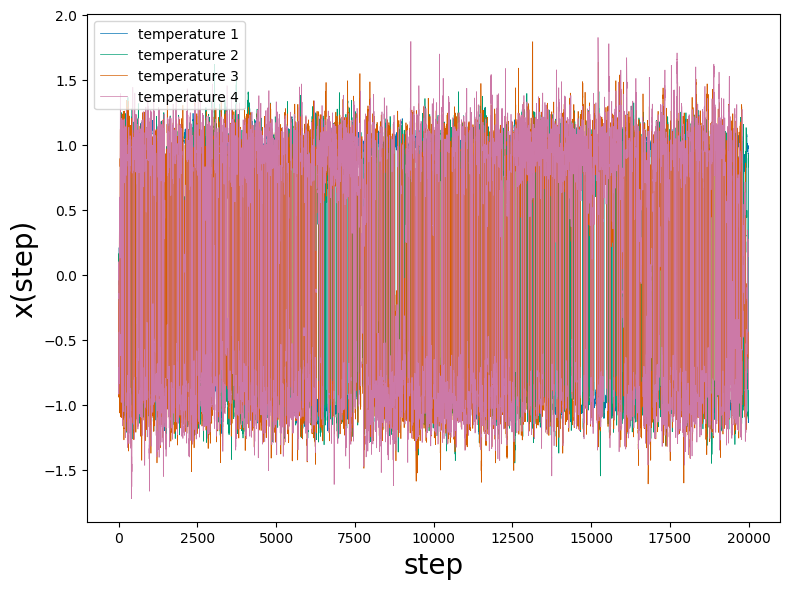

In [50]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_sorted[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 1", "temperature 2", "temperature 3", "temperature 4"])
tight_layout()

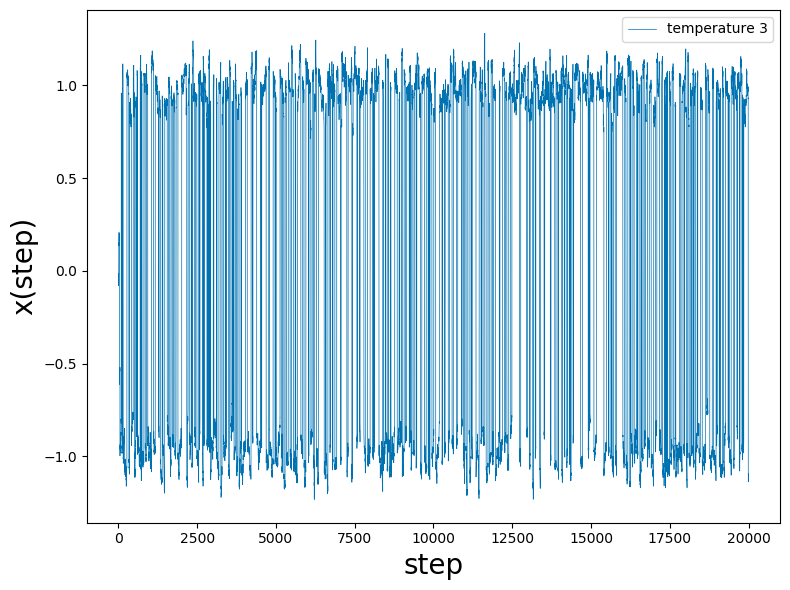

In [51]:
fig, ax = subplots(figsize=(8, 6))

    ax.plot(traj_sorted[1], linewidth=0.5)   

xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["temperature 3"])
tight_layout()

In [52]:
filename = "exIS_weight1.dat"
weight_replica = readdlm(filename);

In [53]:
traj = traj_sorted[1]
weight = weight_replica[:, 1]

for i = 2:nreplica
    traj = [traj; traj_sorted[i]]
    weight = [weight; weight_replica[:, i]]
end
weight .= weight ./ sum(weight)

80000-element Array{Float64,1}:
 1.2223550001222356e-5 
 6.882200000688219e-6  
 3.1399500003139946e-6 
 4.5650000004565e-8    
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 ⋮                     
 0.0                   
 0.0                   
 0.0                   
 0.0                   
 7.0000000007e-10      
 2.4000000002400002e-9 
 1.0000000001e-10      
 1.150000000115e-9     
 2.5000000002500005e-10
 3.050000000305e-9     
 9.80000000098e-9      
 9.07850000090785e-7   

In [54]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid) ./ temperature_replica[1]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [55]:
#pmf_observed, _ = getpmf(traj_replica[1], weight=weight_replica[:, 1], grid_x = collect(x_grid), bandwidth=0.05);
pmf_observed, _ = getpmf(traj, weight=weight, grid_x = collect(x_grid), bandwidth=0.05);

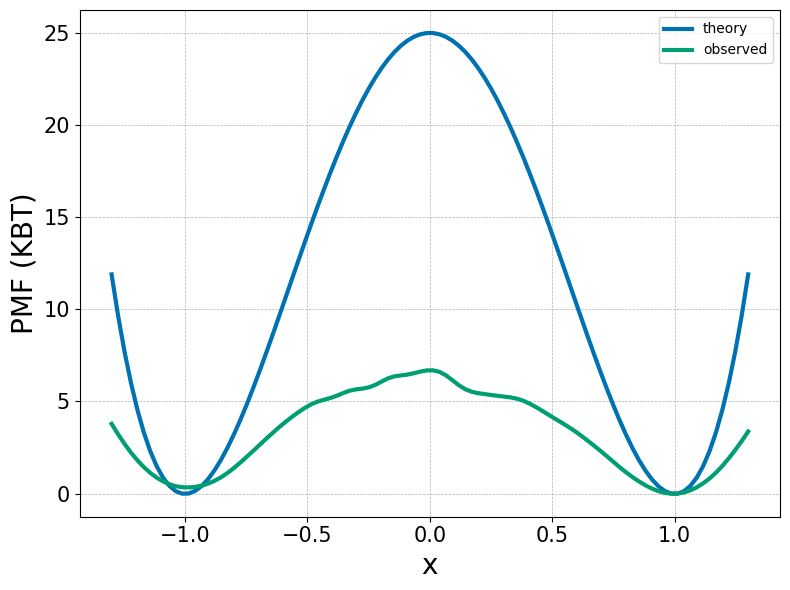

In [56]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("exmcmc_infinite_swap.png", dpi=350)